In [1]:
# limit the thread used by numpy for better parallelization
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Glitch import *
from Triangle.GW import *

from Triangle_BBH.Utils import ParamDict2ParamArr, ParamArr2ParamDict
from scipy.optimize import differential_evolution

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

import multiprocessing
if __name__ == "__main__":
    multiprocessing.set_start_method("fork")
print("number of cpus =", multiprocessing.cpu_count())
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

no cupy 


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


no cupy
no BBHx waveform
number of cpus = 32


## Load data

In [3]:
h5filename = "/media/ps/One Touch/TDCII_Data/2_SingleSource_Dataset/data/MBHB_EOBv4opt_TDIXYZ_clean.h5"
with h5py.File(h5filename, "r") as h5file:
    data_dict = read_dict_from_h5(h5file["/"])
data_dict.keys()

dict_keys(['XYZ', 'time'])

In [4]:
h5paramfilename = "/media/ps/One Touch/TDCII_Data/2_SingleSource_Dataset/data/MBHB_EOB4opt_parameters.h5"
with h5py.File(h5paramfilename, "r") as h5file:
    parameters = read_dict_from_h5(h5file["/"])
parameters.keys()

dict_keys(['chirp_mass', 'coalescence_phase', 'coalescence_time', 'inclination', 'latitude', 'longitude', 'luminosity_distance', 'mass_ratio', 'psi', 'spin_1z', 'spin_2z'])

In [5]:
start_day = 80.
end_day = 120.
select_source_idx = np.where((parameters["coalescence_time"] < end_day)&(parameters["coalescence_time"] > start_day))[0]
parameters_select = dict() 
for k, v in parameters.items(): 
    parameters_select[k] = v[select_source_idx]
N_mbhb = len(parameters_select["chirp_mass"])
N_mbhb

8

In [6]:
# parameter_list = []
# for i in range(len(parameters["chirp_mass"])):
#     tmp = dict()
#     for k, v in parameters.items():
#         tmp[k] = v[i]
#     parameter_list.append(tmp)

# N_mbhb = len(parameter_list)
# N_mbhb

In [8]:
channel_names = list(data_dict["XYZ"].keys())
data_channels = []
for ch in channel_names: 
    data_channels.append(data_dict["XYZ"][ch])
data_channels = np.array(data_channels)
data_time = data_dict["time"]
dt = data_time[1] - data_time[0]

data_time.shape, data_channels.shape 

((6294349,), (3, 6294349))

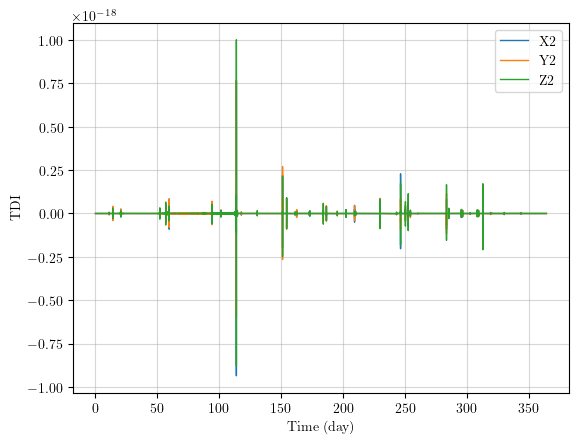

In [9]:
for ich, ch in enumerate(channel_names): 
    plt.plot(data_time/DAY, data_channels[ich], label=ch, linewidth=1)
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc="upper right")
plt.grid(linestyle="-", which="major", alpha=0.5)
plt.grid(linestyle=":", which="minor", alpha=0.4)

## Signal model

In [10]:
# fsample = 1./dt 
# size = len(data_time)
# interp_order = 25

# orbit = Orbit(OrbitDir="../OrbitData/MicroSateOrbitEclipticTCB")
# offset = OffsetFunctions(laser_flag=False, clock_flag=False)
# noise = InstrumentalPSDs(L=L_nominal)

In [11]:
# gw_mbhb = Initialize_GW_response(
#     signal_type="MBHB",
#     parameters=parameters_select,
#     orbit=orbit,
#     approximant="SEOBNRv4_opt",
# )

In [12]:
# ifo = Interferometers(
#     size=size,
#     fsample=fsample,
#     time_frame="ProperTime",  # the time frame of data, 'ProperTime' for the proper times of SCs, 'ClockTime' for the times of on-board clocks (with clock drifts and jitters), default is "ProperTime".
#     acc_noise=False,  # switch of acceleration noise, default is True (this default value also applies to other noises).
#     ro_noise=False,  # switch of readout noise
#     laser_noise=False,  # switch of laser frequency noise
#     clock_noise=False,  # switch of clock noise
#     ob_noise=False,  # switch of optical bench displacement noise
#     bl_noise=False,  # switch of fibre backlink noise
#     op_noise=False,  # switch of optical path noise (all optical paths)
#     ranging_noise=False,  # switch of pseudo ranging noise
#     modulation_noise=False,  # switch of sideband modulation noise
#     orbit_class=orbit,
#     offset_class=offset,
#     noise_class=noise,
#     gw_class=gw_mbhb,
#     fplan=None,
#     order=interp_order,
#     pool=pool,
#     clean_memory=True,  # whether to clean some intermediate variables to save memory
# )

# ifo.SimulateInterferometers()
# m = ifo.OutputMeasurements(mode="decomposed")
# m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool)
# ifo.clean()
# m1.keys()

In [13]:
# tdi = TDI(measurements=m1, delays=m1["ltt"], fsample=m1["fsample"], order=interp_order)
# tdi.CalculateXi(doppler=False, pool=pool)
# tdi.CalculateEta(doppler=False)
# tdi.FastMichelson(doppler=False, channel="XYZ")

In [14]:
# model_channels = np.array([tdi.measurements["X2"], tdi.measurements["Y2"], tdi.measurements["Z2"]])
# model_channels[:, :200] *= 0. 
# model_channels[:, -200:] *= 0. 
# model_channels *= 1./F_LASER
# model_channels.shape, data_channels.shape 

In [ ]:
# signal model 
orbit = Orbit(OrbitDir="../OrbitData/MicroSateOrbitEclipticTCB")
mbhb_waveform_generator = MBHB_Injection(approx_method="SEOBNRv4_opt", buffer=True)
mbhb_response_generator = FastMichelsonTDIResponse(
    orbit=orbit,
    tcb_times=data_time.copy(), 
    use_gpu=False, 
    drop_points=int(1000./dt), 
    interp_method="linear",
    waveform_interp_order=5,
)

In [16]:
model_channels = np.zeros_like(data_channels)
for i in tqdm(range(N_mbhb)):
    tmp = dict()
    for k, v in parameters_select.items():
        tmp[k] = v[i]
    Xtmp, Ytmp, Ztmp = mbhb_response_generator(parameters=tmp, waveform_generator=mbhb_waveform_generator, optimal_combination=False)
    model_channels[0] += Xtmp
    model_channels[1] += Ytmp
    model_channels[2] += Ztmp

100%|██████████| 8/8 [01:47<00:00, 13.48s/it]


## Slice and compare 

In [35]:
# t_start = 10 * DAY 
t_start = np.random.uniform(start_day, end_day) * DAY 
Tobs = 10 * DAY 
t_end = t_start + Tobs 
idx_slice = np.where((data_time >= t_start)&(data_time <= t_end))[0]
time_slice = data_time[idx_slice]
data_slice = data_channels[:, idx_slice]
model_slice = model_channels[:, idx_slice]

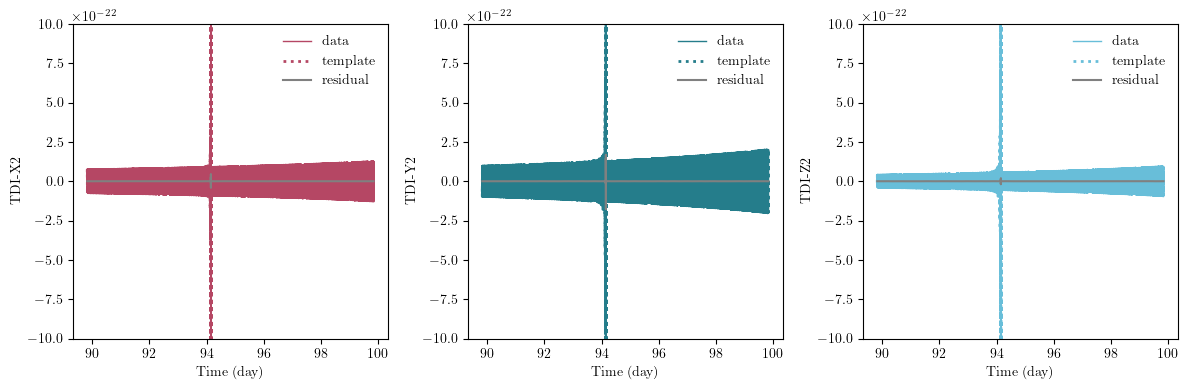

In [36]:
plt.figure(figsize=(12, 4))
channel_names = list(data_dict["XYZ"].keys())
channel_colors = [RED, GREEN1, BLUE]
for ich, nch, cch in zip(range(3), channel_names, channel_colors):
    plt.subplot(131+ich)
    plt.plot(time_slice/DAY, data_slice[ich], label="data", linewidth=1, color=cch)
    plt.plot(time_slice/DAY, model_slice[ich], label="template", linestyle=":", linewidth=2, color=cch)
    plt.plot(time_slice/DAY, data_slice[ich] - model_slice[ich], label="residual", color="grey")
    plt.xlabel("Time (day)")
    plt.ylabel("TDI-"+nch)
    # plt.xlim(7e6, 7.01e6)
    plt.ylim(-1e-21, 1e-21)
    plt.legend(loc="upper right", frameon=False)
plt.tight_layout()

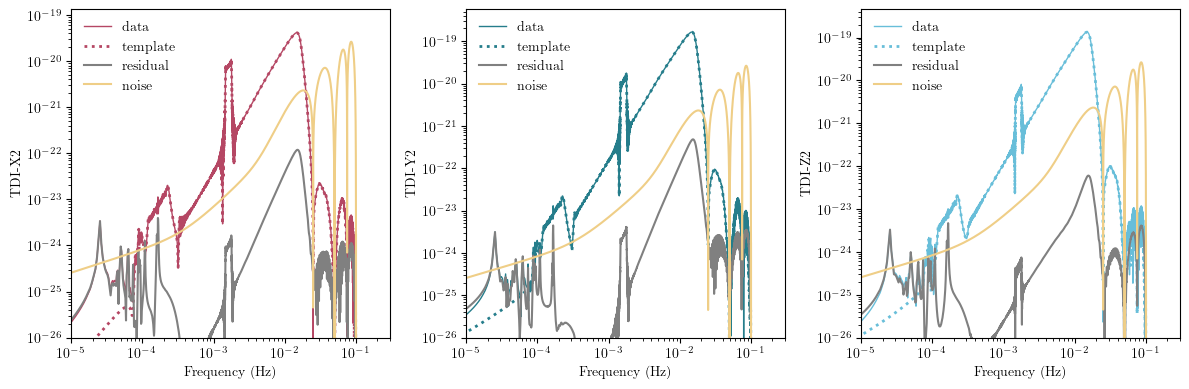

In [37]:
plt.figure(figsize=(12, 4))
channel_names = list(data_dict["XYZ"].keys())
channel_colors = [RED, GREEN1, BLUE]
win_args = dict(window_type="tukey", window_args_dict=dict(alpha=0.01))
PSDfunc = TDIPSDs()
for ich, nch, cch in zip(range(3), channel_names, channel_colors):
    plt.subplot(131+ich)
    ff, xf = FFT_window(data_slice[ich], 1./dt, **win_args)
    plt.loglog(ff, np.abs(xf) * 2 * ff, label="data", linewidth=1, color=cch)
    _, xf1 = FFT_window(model_slice[ich], 1./dt, **win_args)
    plt.loglog(ff, np.abs(xf1) * 2 * ff, label="template", linestyle=":", linewidth=2, color=cch)
    _, xf2 = FFT_window(model_slice[ich] - data_slice[ich], 1./dt, **win_args)
    plt.loglog(ff, np.abs(xf2) * 2 * ff, label="residual", color="grey")
    plt.loglog(ff, np.sqrt(PSDfunc.PSD_X2(ff) * ff), label="noise", color=YELLOW)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("TDI-"+nch)
    plt.xlim(1e-5, 0.3)
    plt.ylim(1e-26,)
    plt.legend(loc="upper left", frameon=False)
plt.tight_layout()